# CP1-24-final

## How to run:

The project is divided into 3 parts. Before beginning, the repository has been merged with https://github.com/ojha-aditya/CP1-24-midterm.git with all commit history. In the same folder as the midterm, now, exist: 

- code subfolder containing module named final.py with the importable functions outlined in the algorithm task.
- data subfolder containing data files with the naming convention 'OA###_sinewalk.csv' and the corresponding markdown files containing the experiment metadata for GPS data of sinewalk.
- documentation subfolder containing this Jupyter notebook FINAL.ipynb containing the plots of raw data, curve fit using non-linear fitting and corresponding fourier transforms and inverse fourier transform of the mean fft.

### Running the code:

Briefly describing the functions from final.py

- the function fahrenheit_to_kelvin() takes the input as temperature in Fahrenheit, and returns the Kelvin temperature
- the function read_temperature() reads the temperature from the metafile located at input path and gives the floating point value for temperature in Fahrenheit. If the file or temperature entry is not found, it gives an unphysically low temperature.
- filename_lister() function makes a list of the files from the given (input) directory, based on the (input) filename filter and extension.
For plotting purpose, we use it to make list of our metafiles containing temperature information.
- non_linear_fit() uses a least squares method to generate the fitting curve for given input dataset against the input ansatz, it gives the output as a directory of optimum fitting parameters. If the dataset is not equidistant it resamples it into one with $2^n$ points.
- get_coordinates() reads into the data file located at the input filepath and converts the latitude and longitude GPS data into x and y coordinates using Mercator representation and outputs the x and y arrays.
- shift_coordinates() takes as input the x and y arrays ideally generated using get_coordinates() to shift them so that the origin is at the starting value.
- resample_data() makes the non-equidistant input data in terms of x and y arrays and samples it into a $2^n \times 2^n$ grid of equidistant data, where $n$ is input.
- get_frequency_axis() is pure python implementation of generating the frequency values usually obtained using numpy.fft, it generates a list of frequency values based on the input equidistant x array, by default to 1/(100m) units.
- is_equidistant() checks whether the input x array (and hence the data) is equidistant or not. Returns a boolean value.
- numpy_wrapper_fft() implements the fft algorithm using numpy.fft module and returns the fft data alongside frequency values using get_frequency_axis()
- numpy_wrpper_ifft() implements the inverse fft algorithm using numpy.fft module and returns the ifft data as array.

### Unit testing module

The module named test_final.py implements the unit test for all above functions using mock data files OA001_sinewalktrial.csv and OA002_sinewalktrial.csv and their corresponding mock metafiles.

### Plotting and documentation

In the final.ipynb Jupyter notebook, we present this documentation and plot the raw GPS data converted to x and y coordinates in the following cells, each of which can be run separately. The libraries imported are standard Python libraries and do not need to separately installed. For fitting we however use the scipy wrapper in this notebook for better clarity (although there is a functioning non linear fitting function in final.py that we wrote). The GPS plot goes in a symmetrical interval because we are using Mercator representation and also because of having shifted the origin. For plotting Fourier Transforms we only plot the real part of fft data. After plotting fft data, we take the mean fft data and remove the noise by filtering, followed by plotting the ifft data again in same units as GPS plot.

# Bibliography

- [Numpy - Discrete Fourier Transform](https://numpy.org/doc/2.1/reference/routines.fft.html)
- [Earth Fact Sheet](https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html)
- [Mercator Projection](https://www.tandfonline.com/doi/full/10.1080/03085694.2014.902580)
- [Pandas](https://pandas.pydata.org/)
- [Scipy](https://scipy.org/)
- Lecture Notes - Prof. Tim Thomay, Computational Physics 1 (2024) UB Physics Dept.

In [1]:
# importing necessary libraries
import sys
#import os
sys.path.append("../code/")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import final
#import pandas as pd
from scipy.optimize import curve_fit

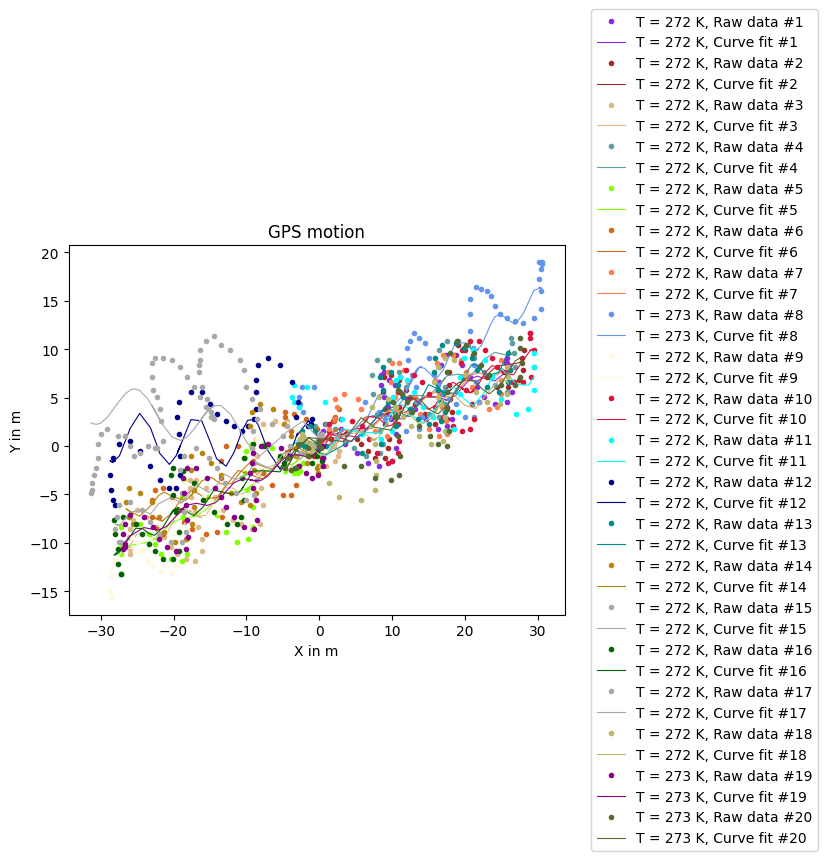

In [2]:
pathname = '../data/' # folder containing all data files

# using file name lister
csv_files = final.filename_lister(pathname,'sinewalk','csv')
md_files = final.filename_lister(pathname,'sinewalk','md')

# fitting function ansatz
def ansatz(x,*p):
    return (p[0]*np.sin(p[1]*x+p[2])+p[3]*x)

# initial guess
init_guess = {'a':2.2, 'b':0.54, 'c':-9.7, 'd':-0.15}

# plotting raw data and fitted curves
data_x = []
for i in range(len(csv_files)):
    csv, md = csv_files[i], md_files[i]
    data = final.get_coordinates(pathname+csv)
    data = data[0][2:],data[1][2:]
    data = final.shift_coordinates(data[0],data[1])
    
    fit = curve_fit(ansatz,data[0],data[1],p0=(1,1,1,1))
    fitted_data = ansatz(data[0], *fit[0])

    temperature = int(final.fahrenheit_to_kelvin(final.read_temperature(pathname+md)))
    label = f'T = {temperature} K'
    color = list(mcolors.CSS4_COLORS.keys())[10:][i]
    data_x.append(data[0])
    plt.plot(data[0], data[1], marker='.', lw=0, color=color, label=label+f', Raw data #{i+1}')
    plt.plot(data[0], fitted_data, lw=0.8, color=color, label=label+f', Curve fit #{i+1}')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    plt.xlabel('X in m')
    plt.ylabel('Y in m')
    plt.title('GPS motion')

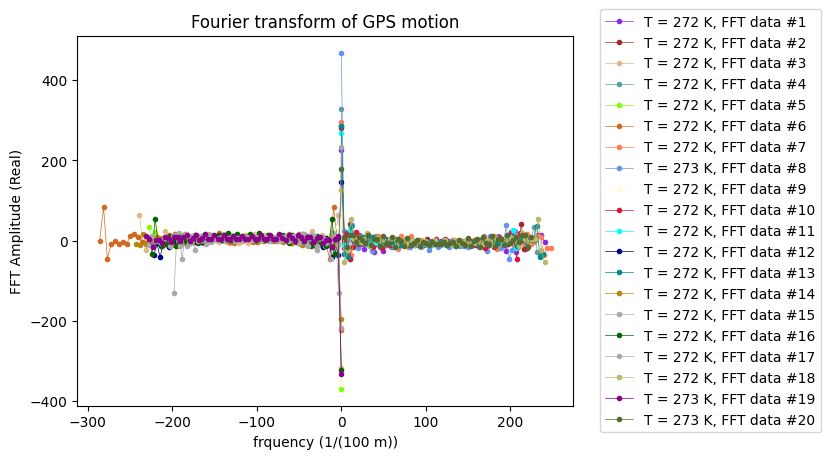

In [3]:
# plotting the Fourier transform of all GPS motions

FFT_x = []
FFT_y = []
data_x = []
for i in range(len(csv_files)):
    csv, md = csv_files[i], md_files[i]
    data = final.get_coordinates(pathname+csv)
    data = data[0][2:],data[1][2:]
    data = final.shift_coordinates(data[0],data[1])
    
    n = int(np.ceil(np.log2(len(data[0]))))
    data = final.resample_data(data[0],data[1],n)
    data_x.append(data[0])
    fftdatay, fftdatax = final.numpy_wrapper_fft(data[0],data[1])
    fftdatax = np.array(fftdatax)
    fftdatay = np.array(fftdatay)
    FFT_x.append(fftdatax)
    FFT_y.append(fftdatay)
    temperature = int(final.fahrenheit_to_kelvin(final.read_temperature(pathname+md)))
    label = f'T = {temperature} K'
    color = list(mcolors.CSS4_COLORS.keys())[10:][i]
    plt.plot(fftdatax.real, fftdatay.real, marker='.', lw=0.5, color=color, label=label+f', FFT data #{i+1}')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    plt.xlabel('frquency (1/(100 m))')
    plt.ylabel('FFT Amplitude (Real)')
    plt.title('Fourier transform of GPS motion')

(64,)


/home/codespace/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/codespace/.local/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Inverse Fourier transform of GPS motion')

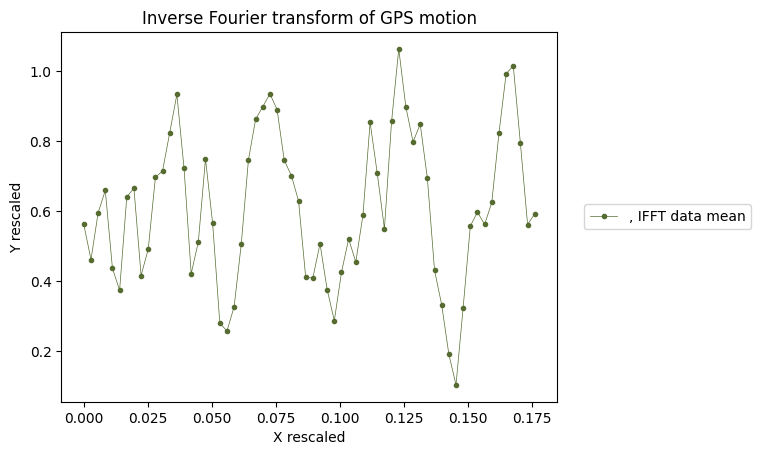

In [4]:
# plotting the inverse Fourier transform of filtered mean fft data

IFFT = []
fft = np.array(FFT_y)
fft_abs = np.abs(fft)
fft_max = np.max(fft_abs, axis=1)
tolerance = 0.05

fft_mask = np.zeros(fft.shape)
for i in range(len(fft_abs)):
    tmp = (np.where(fft_abs[i]==fft_max[i])[0][0])
    tmp1 = (fft[i][tmp])
    if tmp1 >= 0:
        fft_mask = fft[i]> (tolerance*fft_abs[i])
    else:
        fft_mask = fft[i]< (tolerance*fft_abs[i])
    


fft = fft_mask*fft

fft_mean = np.array(fft).mean(axis=0)

ifft = final.numpy_wrapper_ifft(fft_mean)
print(ifft.shape)
plt.plot(np.array(data_x).mean(axis=0), ifft, marker='.', lw=0.5, color=color, label=f', IFFT data mean')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.xlabel('X rescaled')
plt.ylabel('Y rescaled')
plt.title('Inverse Fourier transform of GPS motion')